In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import geopandas
import matplotlib.pyplot as plt
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
from functools import reduce

# Import Data

### Create state DataFrame with: 
 - Median income  
 - GDP
 - largest Industry
 - EV registrations  
 - Total population  
 - Total Area (sq miles)  
 - Geographic coordinates  

In [2]:
# start by populating a df with census data by state
# https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-income-households.html

state_median = pd.read_excel('median_income_state.xlsx', header=(62,63))
state_median.tail(1)

State          2020                         2019  \
   Unnamed: 0_level_1 Median income Standard error Median income   
51            Wyoming         65108           2152         65947   

                           2018                    2017 (40)                 \
   Standard error Median income Standard error Median income Standard error   
51           3820         64467           4012         62867           3362   

            2017  ...          1988                    1987 (21)  \
   Median income  ... Median income Standard error Median income   
51         61073  ...         55733           2310         60306   

                           1986                    1985 (20)                 \
   Standard error Median income Standard error Median income Standard error   
51           3187         53266           1951         50798           2413   

       1984 (19)                 
   Median income Standard error  
51         56671           1739  

[1 rows x 79 columns]

In [3]:
# clean state_median df, clean headers and remove duplicate years
headers = []
drop = []

for year in range(1984, 2021):
    headers.append(year)
    
for header in state_median:
    if type(header[0]) == str and header[0] != 'State':
        new_header = int(header[0][:4])
        
        if new_header in headers:
            drop.append(header)
            state_median.drop([header], axis=1, inplace=True)
        else:
            state_median.rename(columns={header[0] : new_header}, inplace=True)

# create new df with only states and 2020 median income data
states = state_median['State']['Unnamed: 0_level_1']
median2020 = state_median[2020]['Median income']
frame = { 'State': states, '2020 Median Income': median2020 }
state_median2020 = pd.DataFrame(frame)
state_median.tail(1)

State          2020                         2019  \
   Unnamed: 0_level_1 Median income Standard error Median income   
51            Wyoming         65108           2152         65947   

                           2018                         2017                 \
   Standard error Median income Standard error Median income Standard error   
51           3820         64467           4012         61073           3309   

            2016  ...          1991                         1990  \
   Median income  ... Median income Standard error Median income   
51         62378  ...         53992           2569         56747   

                           1989                         1988                 \
   Standard error Median income Standard error Median income Standard error   
51           1909         59668           2605         55733           2310   

            1986                 
   Median income Standard error  
51         53266           1951  

[1 rows x 49 columns]

In [4]:
# https://apps.bea.gov/itable/iTable.cfm?ReqID=70&step=1&acrdn=1
gdp = pd.read_csv('states_gdp.csv', header=4)
gdp.rename(columns={"GeoName": "State", '2020': '2020 GDP'}, inplace=True)
gdp.drop('GeoFips', axis=1, inplace=True)

In [5]:
# https://overheardonconferencecalls.com/business/largest-industry-each-state/
industry = pd.read_csv('bea_industry_data.txt', sep='\t')
industry.drop(['Largest Industry Monetary Contribution (USD, in millions)', 
               'Largest Industry GDP %', '5-Year Change in % of Largest Industry'], axis=1, inplace=True)

In [6]:
# data on EV registrations by state
# https://afdc.energy.gov/data/10962
evreg_state = pd.read_excel('10962-ev-registration-counts-by-state_6-11-21.xlsx', 
                            header=(2), usecols=['State', 'Registration Count'])
evreg_state.rename(columns={"Registration Count": "EV Registration Count"}, inplace=True)
evreg_state.head(1)

,State,EV Registration Count
0,Alabama,2890


In [7]:
# census data on state populations in 2019 (most recent year)
# https://data.census.gov/cedsci/table?q=Total%20Population&g=0100000US%240400000&tid=ACSDP1Y2019.DP05
state_pop = pd.read_excel('ACSDP1Y2019.DP05-2021-12-05T182017.xlsx', 'Data')

# remove repeat instances of Total population LI by taking only top 5 rows
state_pop = state_pop.head(5)
state_pop = state_pop.T # transpose data to match merged df
new_header = state_pop.iloc[0] # take first row to be new header
state_pop = state_pop[1:] # new data minus first row (new header)
state_pop.columns = new_header
state_pop.drop(['Label', 'SEX AND AGE', 'Male', 'Female'], axis=1, inplace=True) # drop all irrelevent data
state_pop.reset_index(inplace=True)
state_pop.rename(columns={"index": "State"}, inplace=True) # rename columns to match naming conventions
state_pop['Total population'] = state_pop['Total population'].str.replace(',', '').astype(int) # remove columns, str to int
state_pop.head(1)

Unnamed: 0,State,Total population
0,Alabama,4903185


In [8]:
# import state area from tsv file
# https://www.census.gov/geographies/reference-files/2010/geo/state-area.html

state_coord_area = pd.read_csv('census_state_data.txt', sep='\t', names=['State', 'Square Miles', 'total Sq. Km.', 'land Sq. Mi.', 
                                  'land Sq. Km.', 'water Sq. Mi.', 'water Sq. Km.', 'inland Sq. Mi.',
                                  'inland Sq. Km.', 'coastal Sq. Mi.', 'coastal Sq. Km.', 'gl Sq. Mi.', 
                                  'gl Sq. Km.', 'territorial Sq. Mi.', 'territorial Sq. Km.', 'Latitude', 'Longitude'])

state_coord_area.drop(['total Sq. Km.', 'land Sq. Mi.','land Sq. Km.', 'water Sq. Mi.', 
                       'water Sq. Km.', 'inland Sq. Mi.', 'inland Sq. Km.', 'coastal Sq. Mi.', 'coastal Sq. Km.', 
                       'gl Sq. Mi.', 'gl Sq. Km.', 'territorial Sq. Mi.', 'territorial Sq. Km.', 'Latitude', 'Longitude'], 
                        axis=1, inplace=True)
state_coord_area.tail(1)

,State,Square Miles
57,U.S. Virgin Islands,733


In [9]:
data_frames = [state_median2020, gdp, industry, evreg_state, state_pop, state_coord_area]

In [10]:
state_info = reduce(lambda  left,right: pd.merge(left,right,on='State', how='inner'), data_frames)

In [11]:
# calculated fields for EV registrations per capita and per sq mile to add context to EV numbers
state_info['EV Registations per $1000000 GDP'] = state_info['EV Registration Count'] / state_info['2020 GDP'] * 1000
state_info['EV Registations per 1000'] = state_info['EV Registration Count'] / state_info['Total population'] * 1000
state_info['Square Miles'] = state_info['Square Miles'].str.replace(',', '').astype(int)
state_info['EV Registations per sq mile'] = state_info['EV Registration Count'] / state_info['Square Miles']                                                                                         

In [13]:
# for state map grapping, we want to drop Alaska, and Hawaii
continental_us_info = state_info.drop([1,10])
# create new df without California which appears to be a huge outlier on EV registrations
without_california = continental_us_info.drop([4])

# Map Analysis

In [14]:
states = geopandas.read_file('shapes/shapefile.shx')
states = states[['NAME','STUSPS','geometry']]
states = states.rename(columns={'NAME':'State'})
state_geo = pd.merge(states, continental_us_info, on='State')
state_geo_noCA = pd.merge(states, without_california, on='State')

In [24]:
def geo_map(data, data_column, title):
    fig, ax = plt.subplots(1, figsize=(10, 10)) # create figure, set size to 10x10
    ax.axis('off') # turn off axis ticks as geo axis aren't useful
    ax.set_title(title, fontdict={'fontsize': '15', 'fontweight' : '2'}) # title from function call
    divider = make_axes_locatable(ax) # use make_axis_locatable function to allow manipulation of legend
    cax = divider.append_axes("right", size="2%", pad=0.1)
    data.plot(column=data_column, linewidth=0.8, edgecolor='0.8', ax=ax, cax=cax, cmap=color, legend=True)

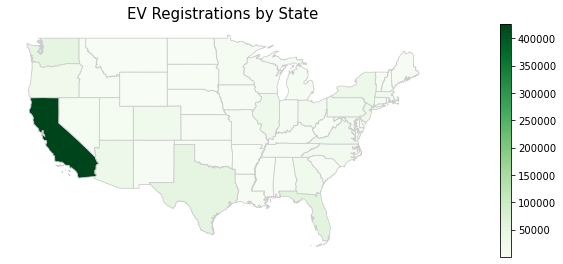

In [25]:
geo_map(state_geo, 'EV Registration Count', 'EV Registrations by State')

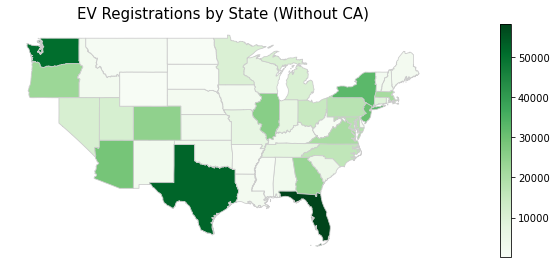

In [17]:
geo_map(state_geo_noCA, 'EV Registration Count', 'EV Registrations by State (Without CA)')

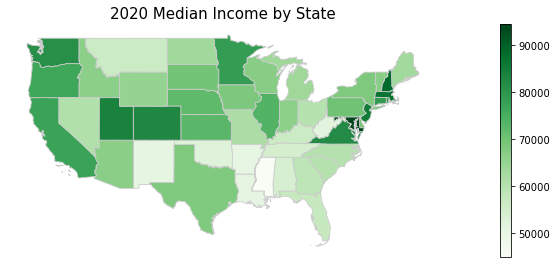

In [18]:
geo_map(state_geo, '2020 Median Income', '2020 Median Income by State')

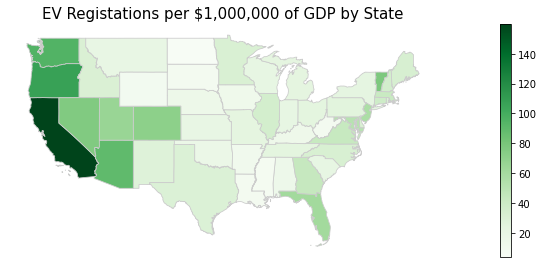

In [19]:
geo_map(state_geo, 'EV Registations per $1000000 GDP', 'EV Registations per $1,000,000 of GDP by State')

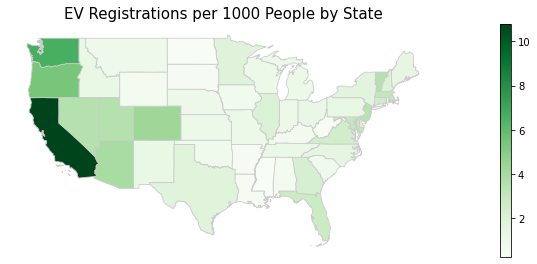

In [20]:
geo_map(state_geo, 'EV Registations per 1000', 'EV Registrations per 1000 People by State')

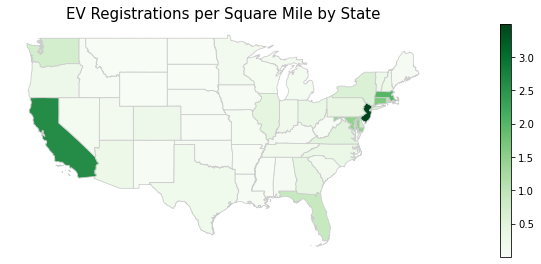

In [21]:
geo_map(state_geo, 'EV Registations per sq mile', 'EV Registrations per Square Mile by State')

<AxesSubplot:title={'center':'Largest Industry by State'}>

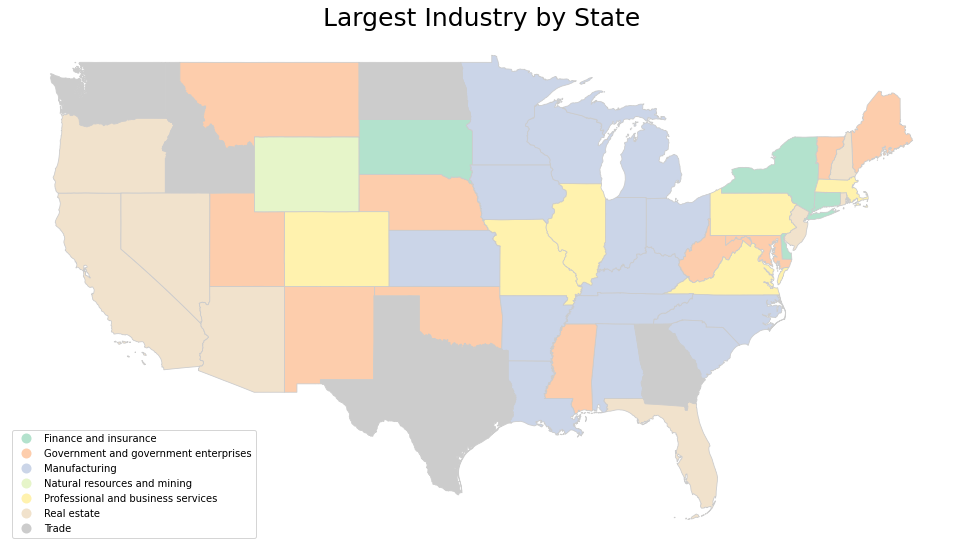

In [41]:
fig, ax = plt.subplots(1, figsize=(17, 17)) # create figure, set size to 10x10
ax.axis('off') # turn off axis ticks as geo axis aren't useful
ax.set_title('Largest Industry by State', fontdict={'fontsize': '25', 'fontweight' : '2'}) # title from function call
state_geo.plot(column='Largest Industry', linewidth=0.8, edgecolor='0.8', ax=ax, 
               cmap='Pastel2', legend=True, legend_kwds={'loc': 'lower left'})

# Trend Analysis

In [48]:
sale_data = pd.read_csv('ev_sale_data.csv')
pivot_df = sale_data.pivot(index='Year', columns='Model', values='Count')
named_pivot_df = pivot_df.loc[:,['Chevy Volt','Nissan Leaf','Smart ED','Mitsubishi I EV','BMW Active E','Prius PHEV','Ford Focus EV','Honda Fit EV',
                'Tesla Model S','Toyota RAV4 EV','Ford C-Max Energi','Honda Accord','Ford Fusion Energi','Chevy Spark','Fiat 500E',
                'Porsche Panamera S E-Hybrid','Cadillac ELR','BMW i3','Mercedes B-Class (B250e)','BMW i8','VW e-Golf','Kia Soul EV',
                'Porsche Cayenne S E-Hybrid','Mercedes S550 Plug', 'Volvo-XC90 Plug In', 'Tesla Model X','BMW X5', 'Hyundai Sonata Plug In',
                'Audi A3 Plug In', 'BMW 3-series Plug-In', 'Mercedes GLE 550e', 'BMW 7-series Plug-in', 'Mercedes C350We','Chevy Bolt',
                'Kia Optima Plug-in','Hyundai Ioniq EV','Chrysler Pacifica Plug-in Hybrid','Cadillac CT6','BMW 5-Series Plug in','MINI Countryman S E',
                'Porsche Panamera 4 E-H', 'Tesla Model 3','Honda Clarity BEV', 'Volvo XC60 Plug In', 'Volvo S90 Plug In','Honda Clarity Plug-in',
                'Mitsubishi Outlander Plug In','Hyundai Ioniq Plug-In','Kia Niro Plug In','Mercedes GLC 350e Hybrid','Jaguar I-Pace',
                'Hyundai Kona Electric', 'Subaru Crosstrek Hybrid','Audi e-tron','Kia Niro EV']]

<AxesSubplot:title={'center':'US PEV Sales by Model]'}, xlabel='Year'>

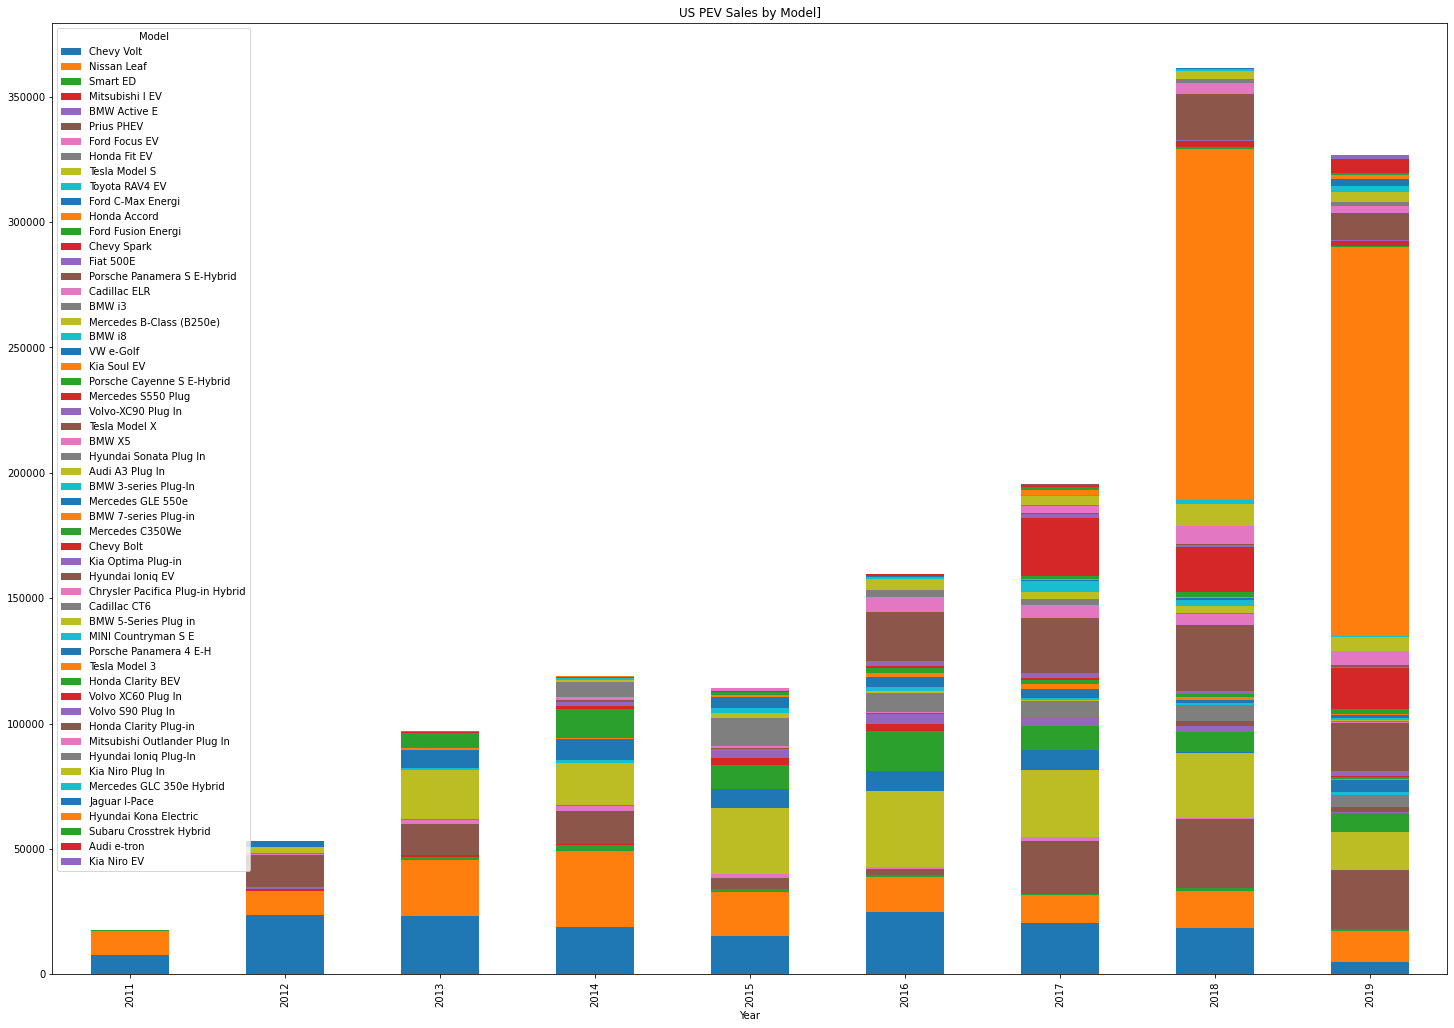

In [49]:
named_pivot_df.plot.bar(stacked=True, figsize=(25,17.5), title = "US PEV Sales by Model]")